In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-07-19_14-38_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

YM       0.25
GC       0.25
ES       0.25
NQ       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    15631.7
GC     6290.4
NQ    14599.6
YM    22150.2
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

58671.9

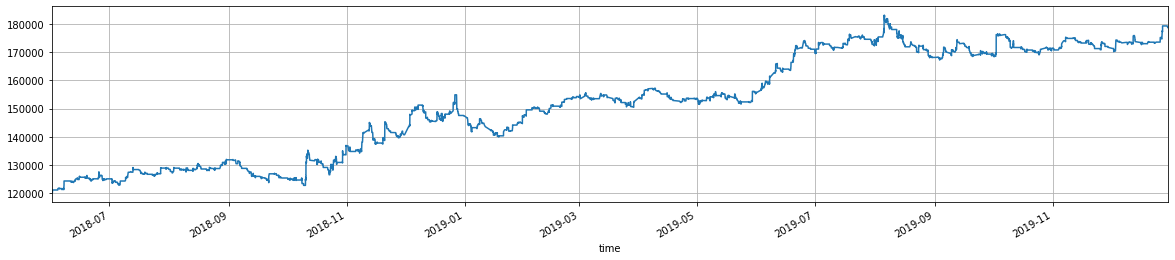

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     348
 GC     880
 NQ    2224
 YM     488
 Name: action, dtype: int64, 3940)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.844660
 GC    2.135922
 NQ    5.398058
 YM    1.184466
 Name: action, dtype: float64, 9.563106796116505)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     730.8
GC    2129.6
NQ    4670.4
YM    1024.8
Name: commission, dtype: float64

In [15]:
df.commission.sum()

8555.600000000002

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.37,14.30,490.83,-268.86,1.83,12.23,440.0
NQ,0.38,13.13,434.42,-250.49,1.73,9.78,1112.0
YM,0.41,90.78,771.89,-390.28,1.98,86.21,244.0
ES,0.43,89.84,978.57,-567.82,1.72,97.13,174.0
total,0.39,29.78,543.42,-297.70,1.83,30.34,1970.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,-0.047915,0.223879,0.460025,0.684843
GC,-0.047915,1.000000,0.020830,0.081721,0.356519
NQ,0.223879,0.020830,1.000000,0.292826,0.675165
YM,0.460025,0.081721,0.292826,1.000000,0.734962
total,0.684843,0.356519,0.675165,0.734962,1.000000


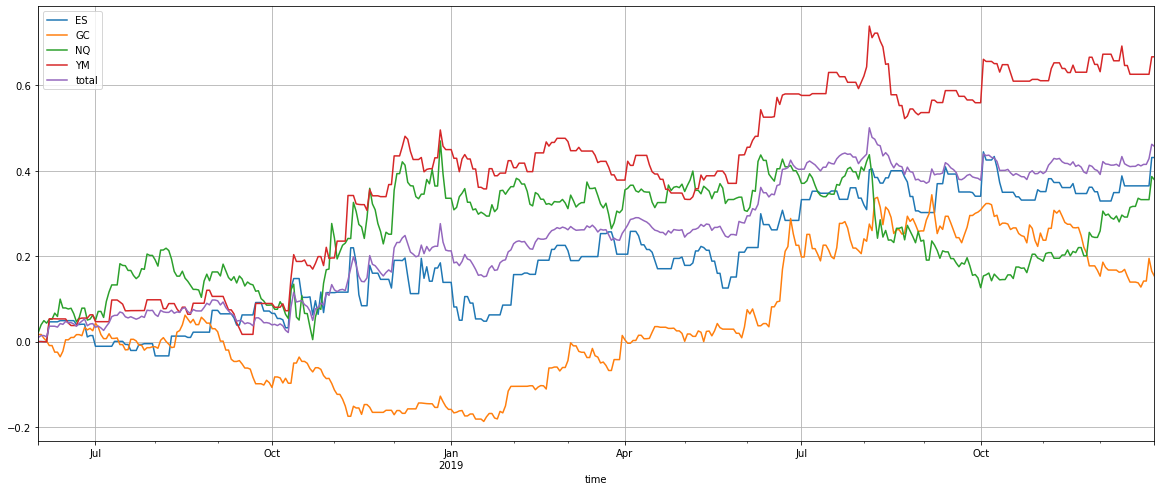

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

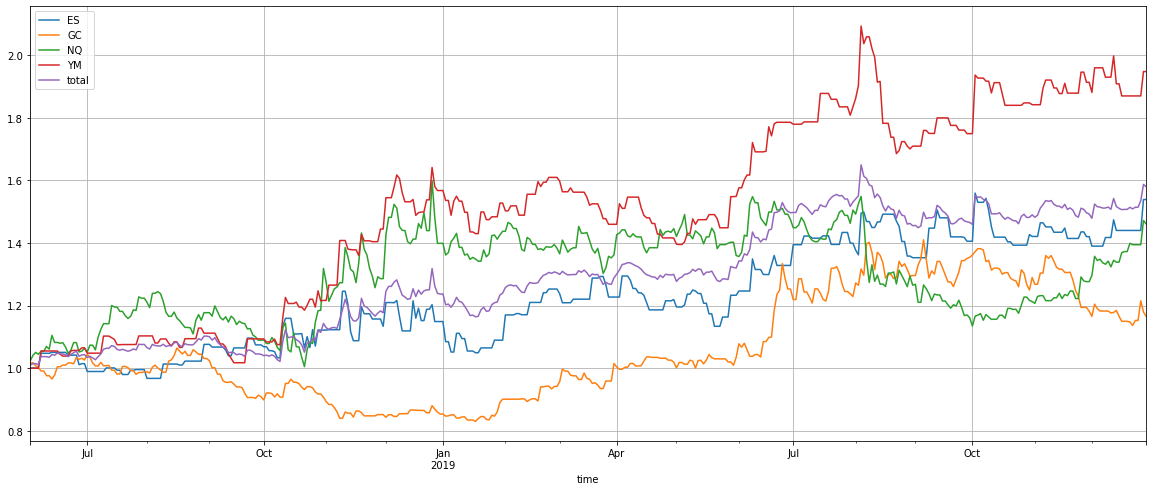

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.301560,0.098066,0.260640,0.503420,0.322503
Cumulative returns,0.538650,0.165265,0.460354,0.947655,0.579333
Annual volatility,0.336414,0.265684,0.366186,0.299440,0.198513
Sharpe ratio,0.947358,0.482719,0.812870,1.508171,1.506483
Calmar ratio,1.910227,0.445248,0.896471,2.585109,2.649381
Stability,0.880830,0.532250,0.175618,0.872319,0.918505
Max drawdown,-0.157866,-0.220251,-0.290740,-0.194738,-0.121727
Omega ratio,1.297280,1.101175,1.170762,1.482302,1.344982
Sortino ratio,1.786419,0.862550,1.358001,3.129888,2.897833
Skew,1.887212,1.371457,0.965452,2.137231,1.657056


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,1.42,2.58,6.37,6.47,4.31
2018-07-31,-1.88,-3.68,15.02,3.58,3.15
2018-08-31,8.10,4.31,-3.80,0.79,2.45
2018-09-30,-0.15,-11.86,-7.48,-1.63,-5.28
2018-10-31,4.40,-0.18,21.07,11.23,9.45
2018-11-30,1.08,-6.10,-2.48,18.75,2.98
2018-12-31,1.34,0.21,8.78,8.53,5.09
2019-01-31,-5.18,5.54,2.75,-2.56,0.24
2019-02-28,15.00,4.51,-3.75,5.38,5.24


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES       54.0
GC       17.0
NQ       46.0
YM       95.0
total    58.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-08 20:39:30,YM,SELL,26093.00,3380.8
2018-10-31 15:48:00,NQ,SELL,6989.50,3370.8
2019-10-02 21:00:00,ES,BUY,2893.75,3283.3
2018-11-09 09:25:00,ES,SELL,2794.00,3283.3
2019-10-02 20:45:00,YM,BUY,26062.00,3210.8
...,...,...,...,...
2018-11-14 14:37:00,ES,BUY,2743.25,-1191.7
2018-10-16 15:23:00,ES,BUY,2773.50,-1291.7
2018-12-20 13:00:30,ES,BUY,2517.75,-1316.7


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-08-05,0.097777,0.041172,0.015820,0.100193,0.063741
2019-10-02,0.109443,0.008183,0.027827,0.107027,0.063120
2018-10-10,0.096943,0.000000,0.069293,0.078887,0.061281
2018-12-03,0.066943,-0.010323,0.108413,0.069360,0.058599
2018-12-26,0.012220,0.026677,0.111353,0.067387,0.054409
...,...,...,...,...,...
2018-10-12,0.000000,0.000000,-0.074200,-0.015807,-0.022502
2019-08-12,0.000000,-0.040151,-0.039673,-0.013640,-0.023366
2018-11-14,-0.072920,0.000000,-0.030060,-0.001280,-0.026065
